In [1]:
import numpy as np
import torch 
import scipy.stats
import math
from scipy.stats import multivariate_normal
from torch import distributions
from matplotlib.pylab import plt
import pymc3 as pm
import random
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,roc_auc_score, roc_curve, auc
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.distributions.normal import Normal
from torch.distributions.categorical import Categorical
import torch.nn.functional as F


In [2]:
def ROC(y_test, y_prob):
    
    false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, y_prob)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    
    plt.figure(figsize = (10,10))
    plt.title('Receiver Operating Characteristic')
    plt.plot(false_positive_rate, true_positive_rate, color = 'red', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1], linestyle = '--')
    plt.axis('tight')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')

# Model 4

$\ Y_i $ ~ $Bernoulli(1/5)$\
$\ Z_{it}|Z_{i,t-1}, Y_i$ ~ $\ N$($0.9 Z_{i,t-1}$,$50.1^{Y_i}$)\
$\ X_{it}|Z_{i,t}$ ~ $\ Categorical$($\sigma(\Psi Z_{i,t}$))\




## 1. Data Simulation

In [3]:
zdim = 1
xdim = 100
N = 2000 # patients
T = 2 # time steps

Z_true = torch.zeros((N, T, zdim)) # latent 
logPZ_true = torch.zeros((N, T)) 
X = torch.zeros((N, T)) # observed
PX = torch.zeros((N, T, xdim)) 
logPX = torch.zeros((N, T, xdim))
X_onehot = torch.zeros((N,T,xdim))
Psi = torch.arange(0,xdim*0.01,0.01).reshape(xdim,zdim) # should be full rank , xdim > zdim
Y = torch.zeros(N)

### to simplify, the z_true mean for sick patients could be 1 and normal people be 0.

success_prob = 0.5
Y = torch.distributions.Bernoulli(success_prob).sample((N,))
cov_diag = torch.pow(50.1, Y)

for t in range(0,T):
    # Zit|Zi,t-1, Yi
    meanz = (0.9*Z_true[:,t-1]).squeeze(1) if t!= 0 else torch.zeros((N,))
    Zt = Normal(meanz, cov_diag.sqrt())
    Z_true[:,t] = Zt.sample().unsqueeze(1)
    logPZ_true[:,t] = Zt.log_prob(Z_true[:,t].squeeze(1))

    #Xit|Zit
    Psi_z = torch.matmul(Z_true[:,t], Psi.t())
    PX[:,t] = F.softmax(Psi_z, dim = 1)
    Xt = Categorical(PX[:,t])
    Xit = Xt.sample()
    X[:,t] = Xit
    X_onehot[:,t] = F.one_hot(Xit, num_classes = xdim)


## 2. Train-Test Split

In [4]:
idx = torch.randperm(N)
train_idx = idx[:math.floor(0.8*N)]
test_idx = idx[math.floor(0.8*N):]
X_train = X_onehot[train_idx,:,:]
X_test = X_onehot[test_idx,:,:]
xd1, xd2, xd3 = X_train.shape
X_train_lr = X_train.view(xd1, xd2*xd3)
xd1, xd2, xd3 = X_test.shape
X_test_lr = X_test.view(xd1, xd2*xd3)

In [5]:
y_train = Y[train_idx]
y_test = Y[test_idx]

## 3. Logistic Regression

In [6]:
lr_accuracy = torch.zeros(T)

clf = LogisticRegression().fit(X_train_lr, y_train)
y_prob_lr = clf.predict_proba(X_test_lr)[:,1]
y_pred_lr = 1*(y_prob_lr > 0.5)

lr_accuracy = accuracy_score(y_test,y_pred_lr)

In [7]:
print("Logistic regression accuracy in test:", lr_accuracy)

Logistic regression accuracy in test: 0.6625


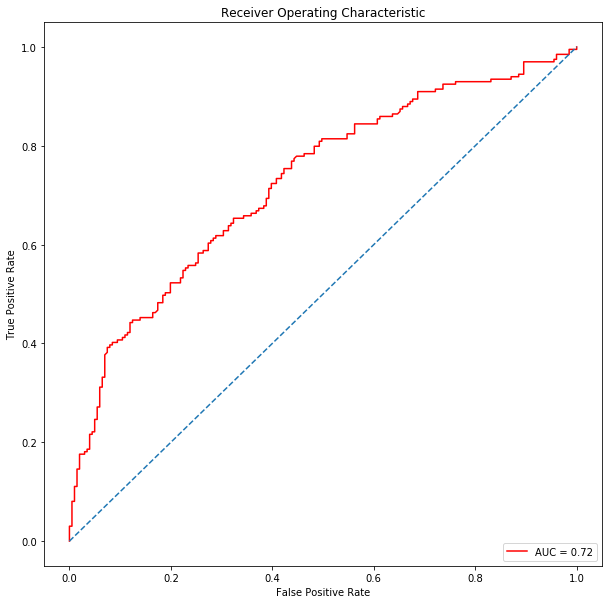

In [8]:
ROC(y_test, y_prob_lr)

## 4. Numerical integration approach

$\ Z_{it}^{(k)}|Z_{i,t-1}^{(k)}, Y_i$ ~ $\ N$($0.9 Z_{i,t-1}^{(k)}$,$50.1^{Y_i}$)\
$\ X_{it}|Z_{i,t}$ ~ $\ Categorical$($\sigma(\Psi Z_{i,t}$))

$P(X|Y = 1) = E_{P(Z|Y = 1)} [P(X|Z)] \approx \frac{1}{K} \sum_{k=1}^{K} P(X|Z^{(k)}),  Z^{(k)} \sim P(Z^{(k)}|Y = 1)$\
$P(X|Y = 0) = E_{P(Z|Y = 0)} [P(X|Z)] \approx \frac{1}{K} \sum_{k=1}^{K} P(X|Z^{(k)}),  Z^{(k)} \sim P(Z^{(k)}|Y = 0)$

$P(Y = 1 |X) = \frac{P(X|Y = 1)P(Y=1)}{P(X|Y = 1)P(Y=1) + P(X|Y = 0)P(Y=0)}$

### 4.1 Inference Z and X generation
$\ Z_{it}^{(k)}|Z_{i,t-1}^{(k)}, Y_i$ ~ $\ N$($0.9 Z_{i,t-1}^{(k)}$,$50.1^{Y_i}$)\
$\ X_{it}|Z_{i,t}$ ~ $\ Categorical$($\sigma(\Psi Z_{i,t}$))


In [9]:
K = 1000 # 1000 simulations

Z = torch.zeros((K, N, T)) 
logPX_y = torch.zeros((2, K, N, T))
Psi = torch.arange(0,xdim*0.01,0.01).reshape(1,1,xdim) 
cov_diag = torch.tensor([1,50.1])

for t in range(0,T):
    for y in range(2):
        meanz = 0.9*Z[:,:,t-1] if t!= 0 else torch.zeros((K,N))        
        Zt = Normal(meanz, cov_diag[y].sqrt())
        Z[:,:,t] = Zt.sample()

        Psi_z = torch.matmul(Z[:,:,t].unsqueeze(2), Psi)
        logPX  = F.log_softmax(Psi_z, dim = 1)
        Xt = Categorical(logPX.exp())
        logPX_y[y,:,:,t] = Xt.log_prob(X[:,t].unsqueeze(0))

### 4.2 Approximate P(X|Y)
$P(X|Y = 1) = E_{P(Z|Y = 1)} [P(X|Z)] \approx \frac{1}{K} \sum_{k=1}^{K} P(X|Z^{(k)}),  Z^{(k)} \sim P(Z^{(k)}|Y = 1)$\
$P(X|Y = 0) = E_{P(Z|Y = 0)} [P(X|Z)] \approx \frac{1}{K} \sum_{k=1}^{K} P(X|Z^{(k)}),  Z^{(k)} \sim P(Z^{(k)}|Y = 0)$


In [10]:
ElogPX_1k = torch.logsumexp(logPX_y[1], dim = 0) - np.log(K)
ElogPX_1 = torch.mean(ElogPX_1k,dim = 1)

ElogPX_0k = torch.logsumexp(logPX_y[0], dim = 0) - np.log(K)
ElogPX_0 = torch.mean(ElogPX_0k,dim = 1)


### 4.3 Posterior distribution
$P(Y = 1 |X) = \frac{P(X|Y = 1)P(Y=1)}{P(X|Y = 1)P(Y=1) + P(X|Y = 0)P(Y=0)}$

In [11]:
logPX_Y1 = ElogPX_1 + np.log(success_prob)
logPX_Y0 = ElogPX_0 + np.log(1-success_prob)
logPY1_X = logPX_Y1 - (logPX_Y1.exp() + logPX_Y0.exp()).log()
logPY1_X.exp()
Y_pred = 1*(logPY1_X.exp() > 0.5)

In [12]:
print("Numerical integration classification accuracy in testing:",torch.mean((Y_pred[test_idx] == y_test).float()).item())

Numerical integration classification accuracy in testing: 0.5774999856948853


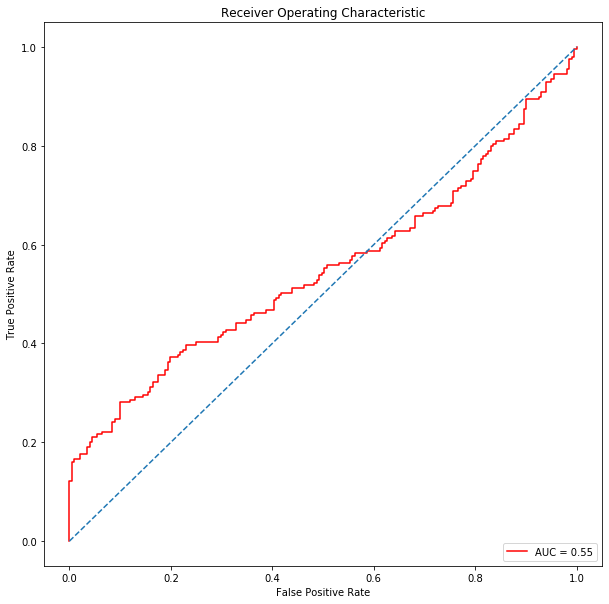

In [13]:
ROC(y_test, logPY1_X.exp()[[test_idx]])